In [ ]:
!pip install polars 
!pip install seaborn 
!pip install scikit-learn


In [3]:
import numpy as np
import polars as pl
import seaborn as sns
from sklearn.linear_model import LinearRegression

Intercept: -0.030315418119926107
Coefficients: [ 0.18383058  4.96460857 -3.00001998  0.90953631]
True Intercept: 3
True Coefficients: 2 (on Team_Strength), 5, -3, 1


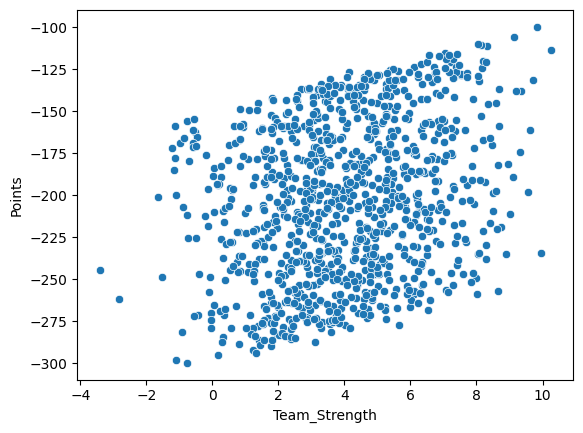

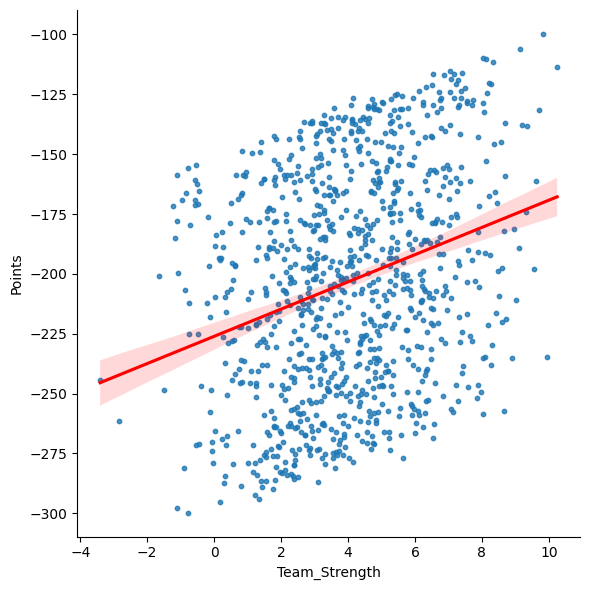

In [12]:
# Define the true parameter values
beta0 = 3  # Intercept
beta1 = 2  # Effect of CoachChange on Team_Strength
beta2 = 5  # Effect of Team_Strength on Points
beta3 = -3  # Effect of Opponent_Strength on Points
beta4 = 1  # Effect of Match_Location on Points
n = 1000  # Sample size
noise_sd = 2  # Standard deviation of random noise

# Simulate predictors
sim_data = (
    pl.DataFrame({
        "CoachChange": np.random.choice([0, 1], size=n),  # Binary: 0 = No change, 1 = Change
        "Opponent_Strength": np.random.uniform(50, 100, size=n),  # Continuous: Opponent strength
        "Match_Location": np.random.choice([0, 1], size=n)  # Binary: 0 = Away, 1 = Home
    })
    # Simulate Team_Strength as a mediator influenced by CoachChange
    .with_columns([
        (
            beta0
            + beta1 * pl.col("CoachChange")
            + np.random.normal(0, noise_sd, size=n)
        ).alias("Team_Strength")
    ])
    # Simulate the outcome variable (Points)
    .with_columns([
        (
            beta2 * pl.col("Team_Strength")
            + beta3 * pl.col("Opponent_Strength")
            + beta4 * pl.col("Match_Location")
            + np.random.normal(0, noise_sd, size=n)
        ).alias("Points")
    ])
)

# Convert Polars DataFrame to NumPy array for visualization
sim_data_numpy = sim_data.to_numpy()

# Extract column names for reference
columns = sim_data.columns

# Create a Pandas DataFrame for visualization
import pandas as pd
sim_data_df = pd.DataFrame(sim_data_numpy, columns=columns)

# Visualize the data (example: Team_Strength vs Points)
sns.scatterplot(data=sim_data_df, x="Team_Strength", y="Points")
sns.lmplot(
    data=sim_data_df,
    x="Team_Strength",
    y="Points",
    height=6,
    aspect=1,
    scatter_kws={"s": 10},
    line_kws={"color": "red"}
)

# Specify the X matrix and y vector
X = sim_data.select(["CoachChange", "Team_Strength", "Opponent_Strength", "Match_Location"]).to_numpy()
y = sim_data["Points"].to_numpy()

# Create a linear regression model
model = LinearRegression(fit_intercept=True)

# Train the model
model.fit(X, y)

# Print the coefficients
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")

# Compare to true parameter values
print(f"True Intercept: {beta0}")
print(f"True Coefficients: {beta1} (on Team_Strength), {beta2}, {beta3}, {beta4}")

I ran multiple simulations with different sample sizes to estimate the causal effects in my model. While most coefficients stabilized close to their true values, the effect of CoachChange was consistently underestimated. This suggests that its impact is mostly mediated through Team_Strength, which absorbs much of its influence. Despite some variation in the intercept and minor deviations in Match_Location, the final estimates are reasonable, with Team_Strength and Opponent_Strength aligning well with their expected values.